## Setup

In [1]:
import string
import jax
import jax.numpy as jnp
import optax
import hodel
from helper import (
    Triplet,
    get_W,
    fixed_0,
    NNTriplet,
    HoDELNN,
    get_stress,
    from_csv,
)
import matplotlib.pyplot as plt

# To match submission figures
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "font.size": 8,
        "axes.labelsize": 8,
        "legend.fontsize": 7,
        "figure.dpi": 300,
    }
)

(lambdas, xf_stars), (strain_stars, stress_stars), aux = from_csv()

## Learning

### Warm-start Constant K

In [2]:
key = jax.random.PRNGKey(0)
xf_stars = xf_stars * (1 + 0.01 * jax.random.normal(key, xf_stars.shape))
xf0 = xf_stars[0]

# Initialize const K simulator
ts = Triplet.init(xf0, jnp.array([0.0]))
ts_sim = hodel.HODEL(ts.get_energy, get_W, fixed_0)

bounded_optim = optax.chain(
    optax.adam(1e-1),
    optax.keep_params_nonnegative(),  # Negative K inverts energy
)
out_Theta, L = ts_sim.learn(
    lambdas,
    xf0,
    xf_stars,
    jnp.array([1.0, 1.0]),
    aux,
    method=hodel.Method.Residual,
    optim=bounded_optim,
    nepochs=100,
)
start_Theta = jnp.mean(out_Theta)  # Average L and R spring
print("Warm-start K:", start_Theta)

Warm-start K: 0.009313485


### HoDEL

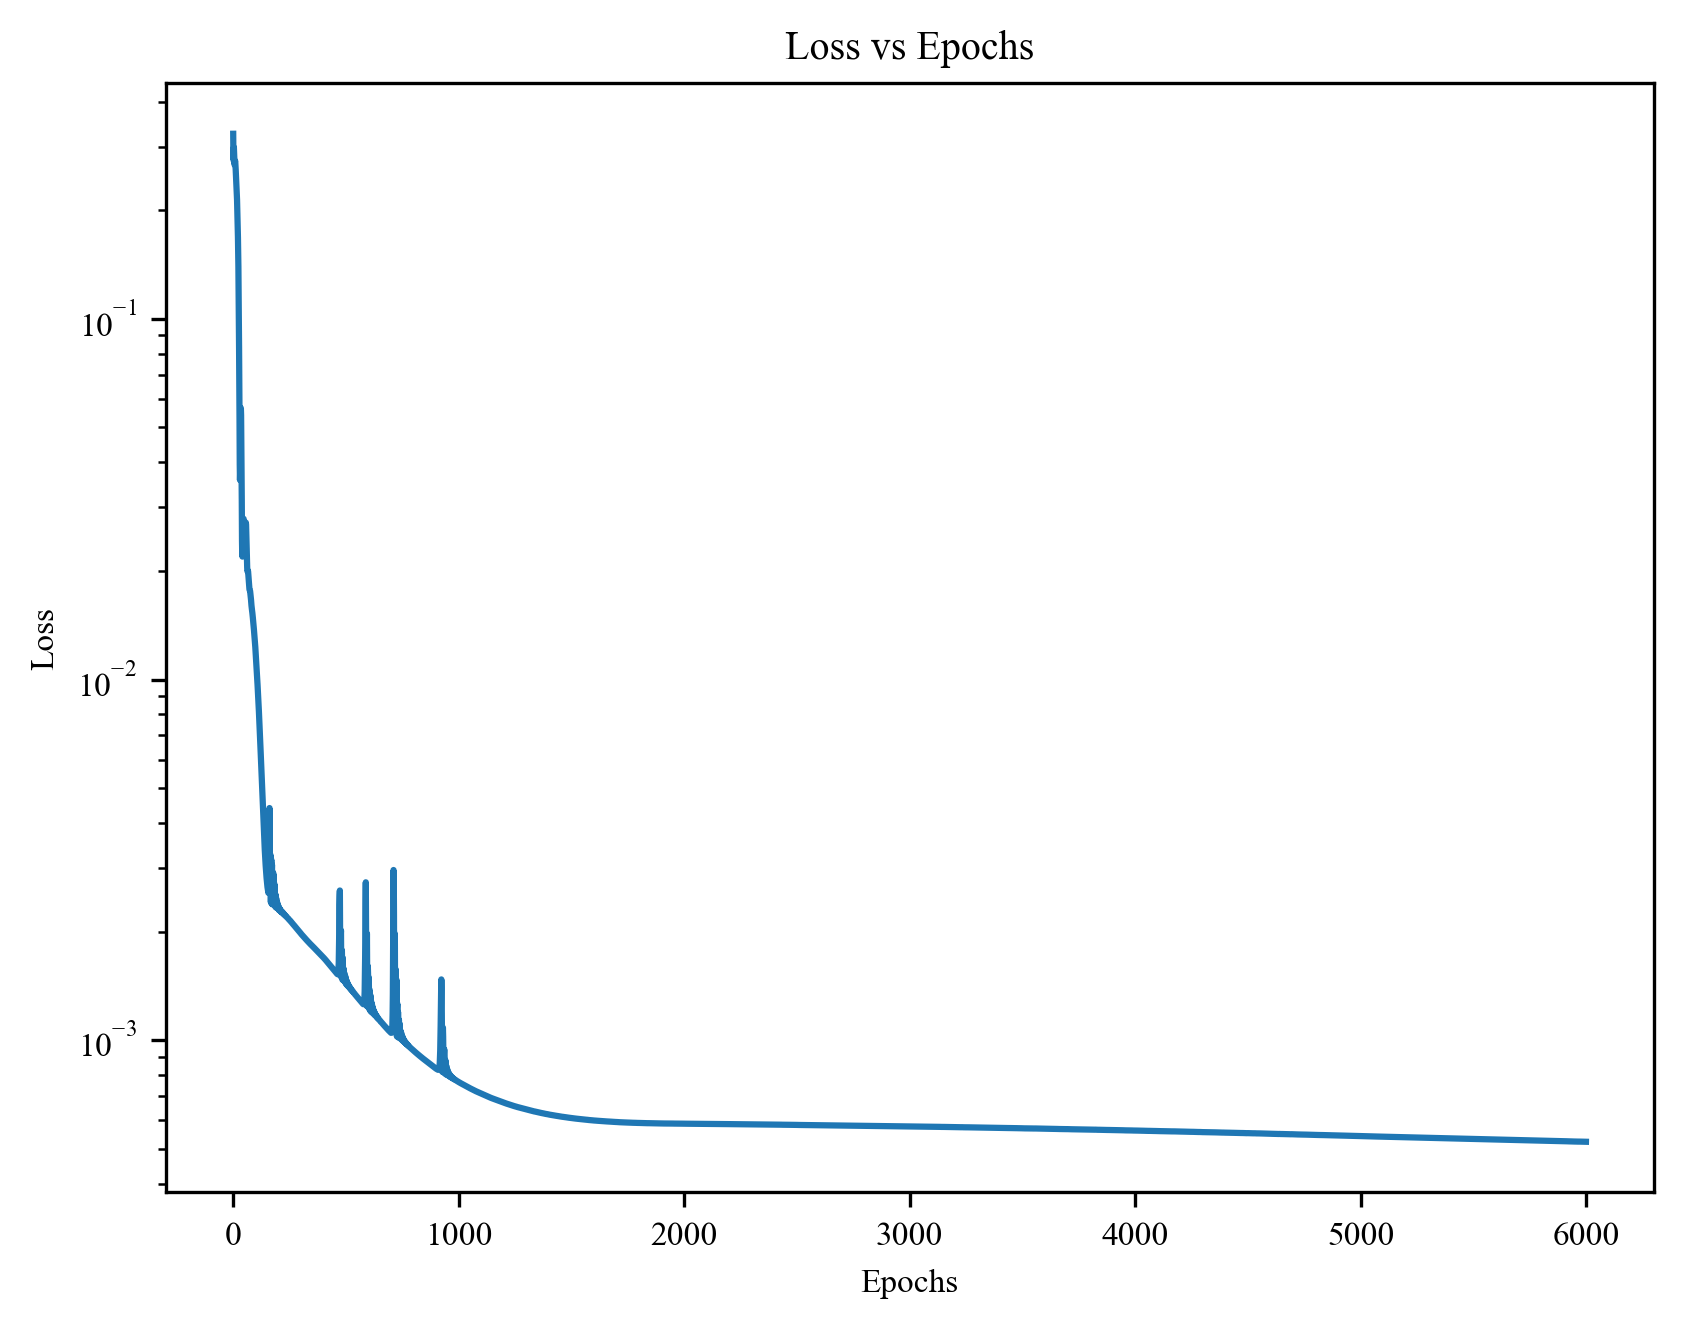

In [3]:
model = HoDELNN(10, start_Theta)
nn_energy = NNTriplet.init(xf0, jnp.array([0.0]), model=model)
nn_sim = hodel.HODEL(nn_energy.get_energy, get_W, fixed_0)
params = model.init(key, jnp.zeros(1))

lr = 1e-2
nepochs = 6000
schedule = optax.cosine_decay_schedule(init_value=lr, decay_steps=2000, alpha=1e-2)
final_params, L = nn_sim.learn(
    lambdas,
    xf0,
    xf_stars,
    params,
    aux,
    method=hodel.Method.Minimization,
    config=hodel.SolverConfig(nsteps=2),
    optim=optax.adam(schedule),
    nepochs=nepochs,
)

plt.plot(L)
plt.yscale("log")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Visualization

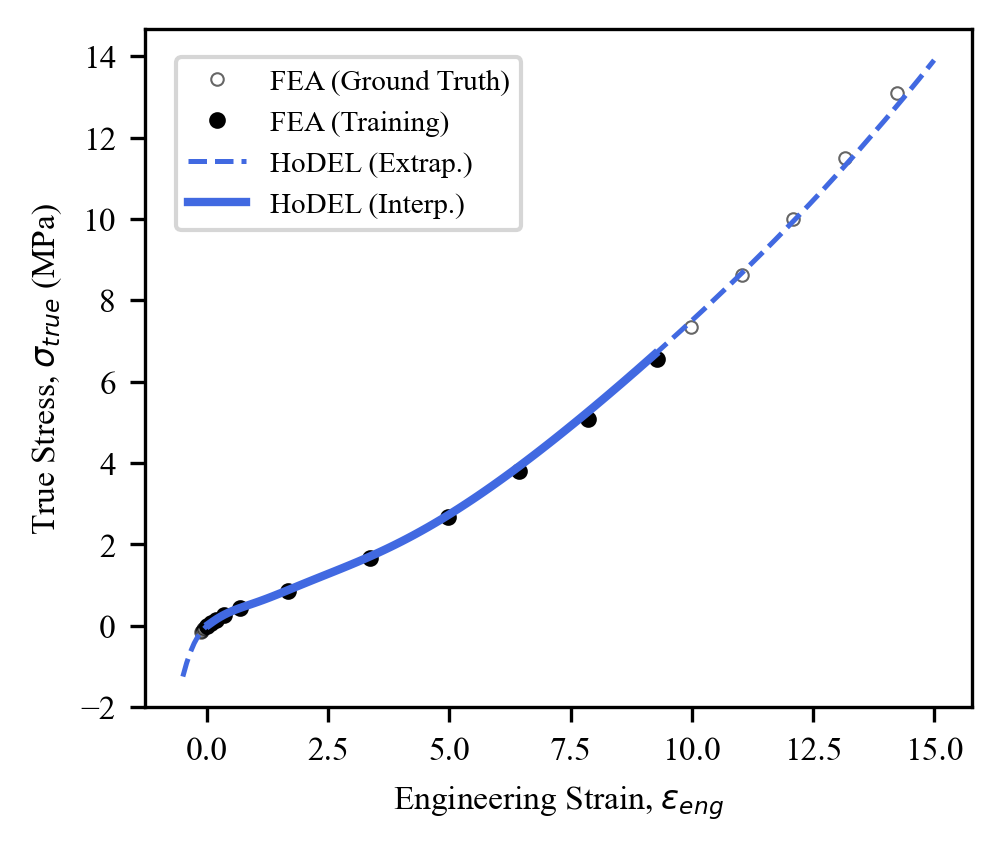

In [4]:
# Figure 1
strain = jnp.linspace(-0.5, 15, 200)
true_stress = get_stress(strain, nn_energy, final_params)
fig, ax = plt.subplots(figsize=(3.25, 2.75))
ax.plot(
    strain_stars,
    stress_stars,
    "o",
    markerfacecolor="none",
    markeredgecolor="black",
    markeredgewidth=0.5,
    markersize=3,
    alpha=0.6,
    label="FEA (Ground Truth)",
)
ax.plot(
    strain_stars[5:16],
    stress_stars[5:16],
    "o",
    color="black",
    markersize=3,
    label="FEA (Training)",
)
ax.plot(
    strain,
    true_stress,
    color="royalblue",
    linestyle="--",
    linewidth=1.2,
    label="HoDEL (Extrap.)",
)
mask = (strain >= strain_stars[5]) & (strain <= strain_stars[15])
ax.plot(
    strain[mask],
    true_stress[mask],
    color="royalblue",
    linestyle="-",
    linewidth=2.0,
    label="HoDEL (Interp.)",
)
ax.set_ylabel(r"True Stress, $\sigma_{true}$ (MPa)")
ax.set_xlabel(r"Engineering Strain, $\epsilon_{eng}$")
ax.legend(frameon=True, loc="upper left", bbox_to_anchor=(0.02, 0.98))
plt.tight_layout(pad=0.5)
#plt.savefig("1d_arruda_boyce_stress_strain.pdf", bbox_inches="tight")
plt.show()

### Benchmark

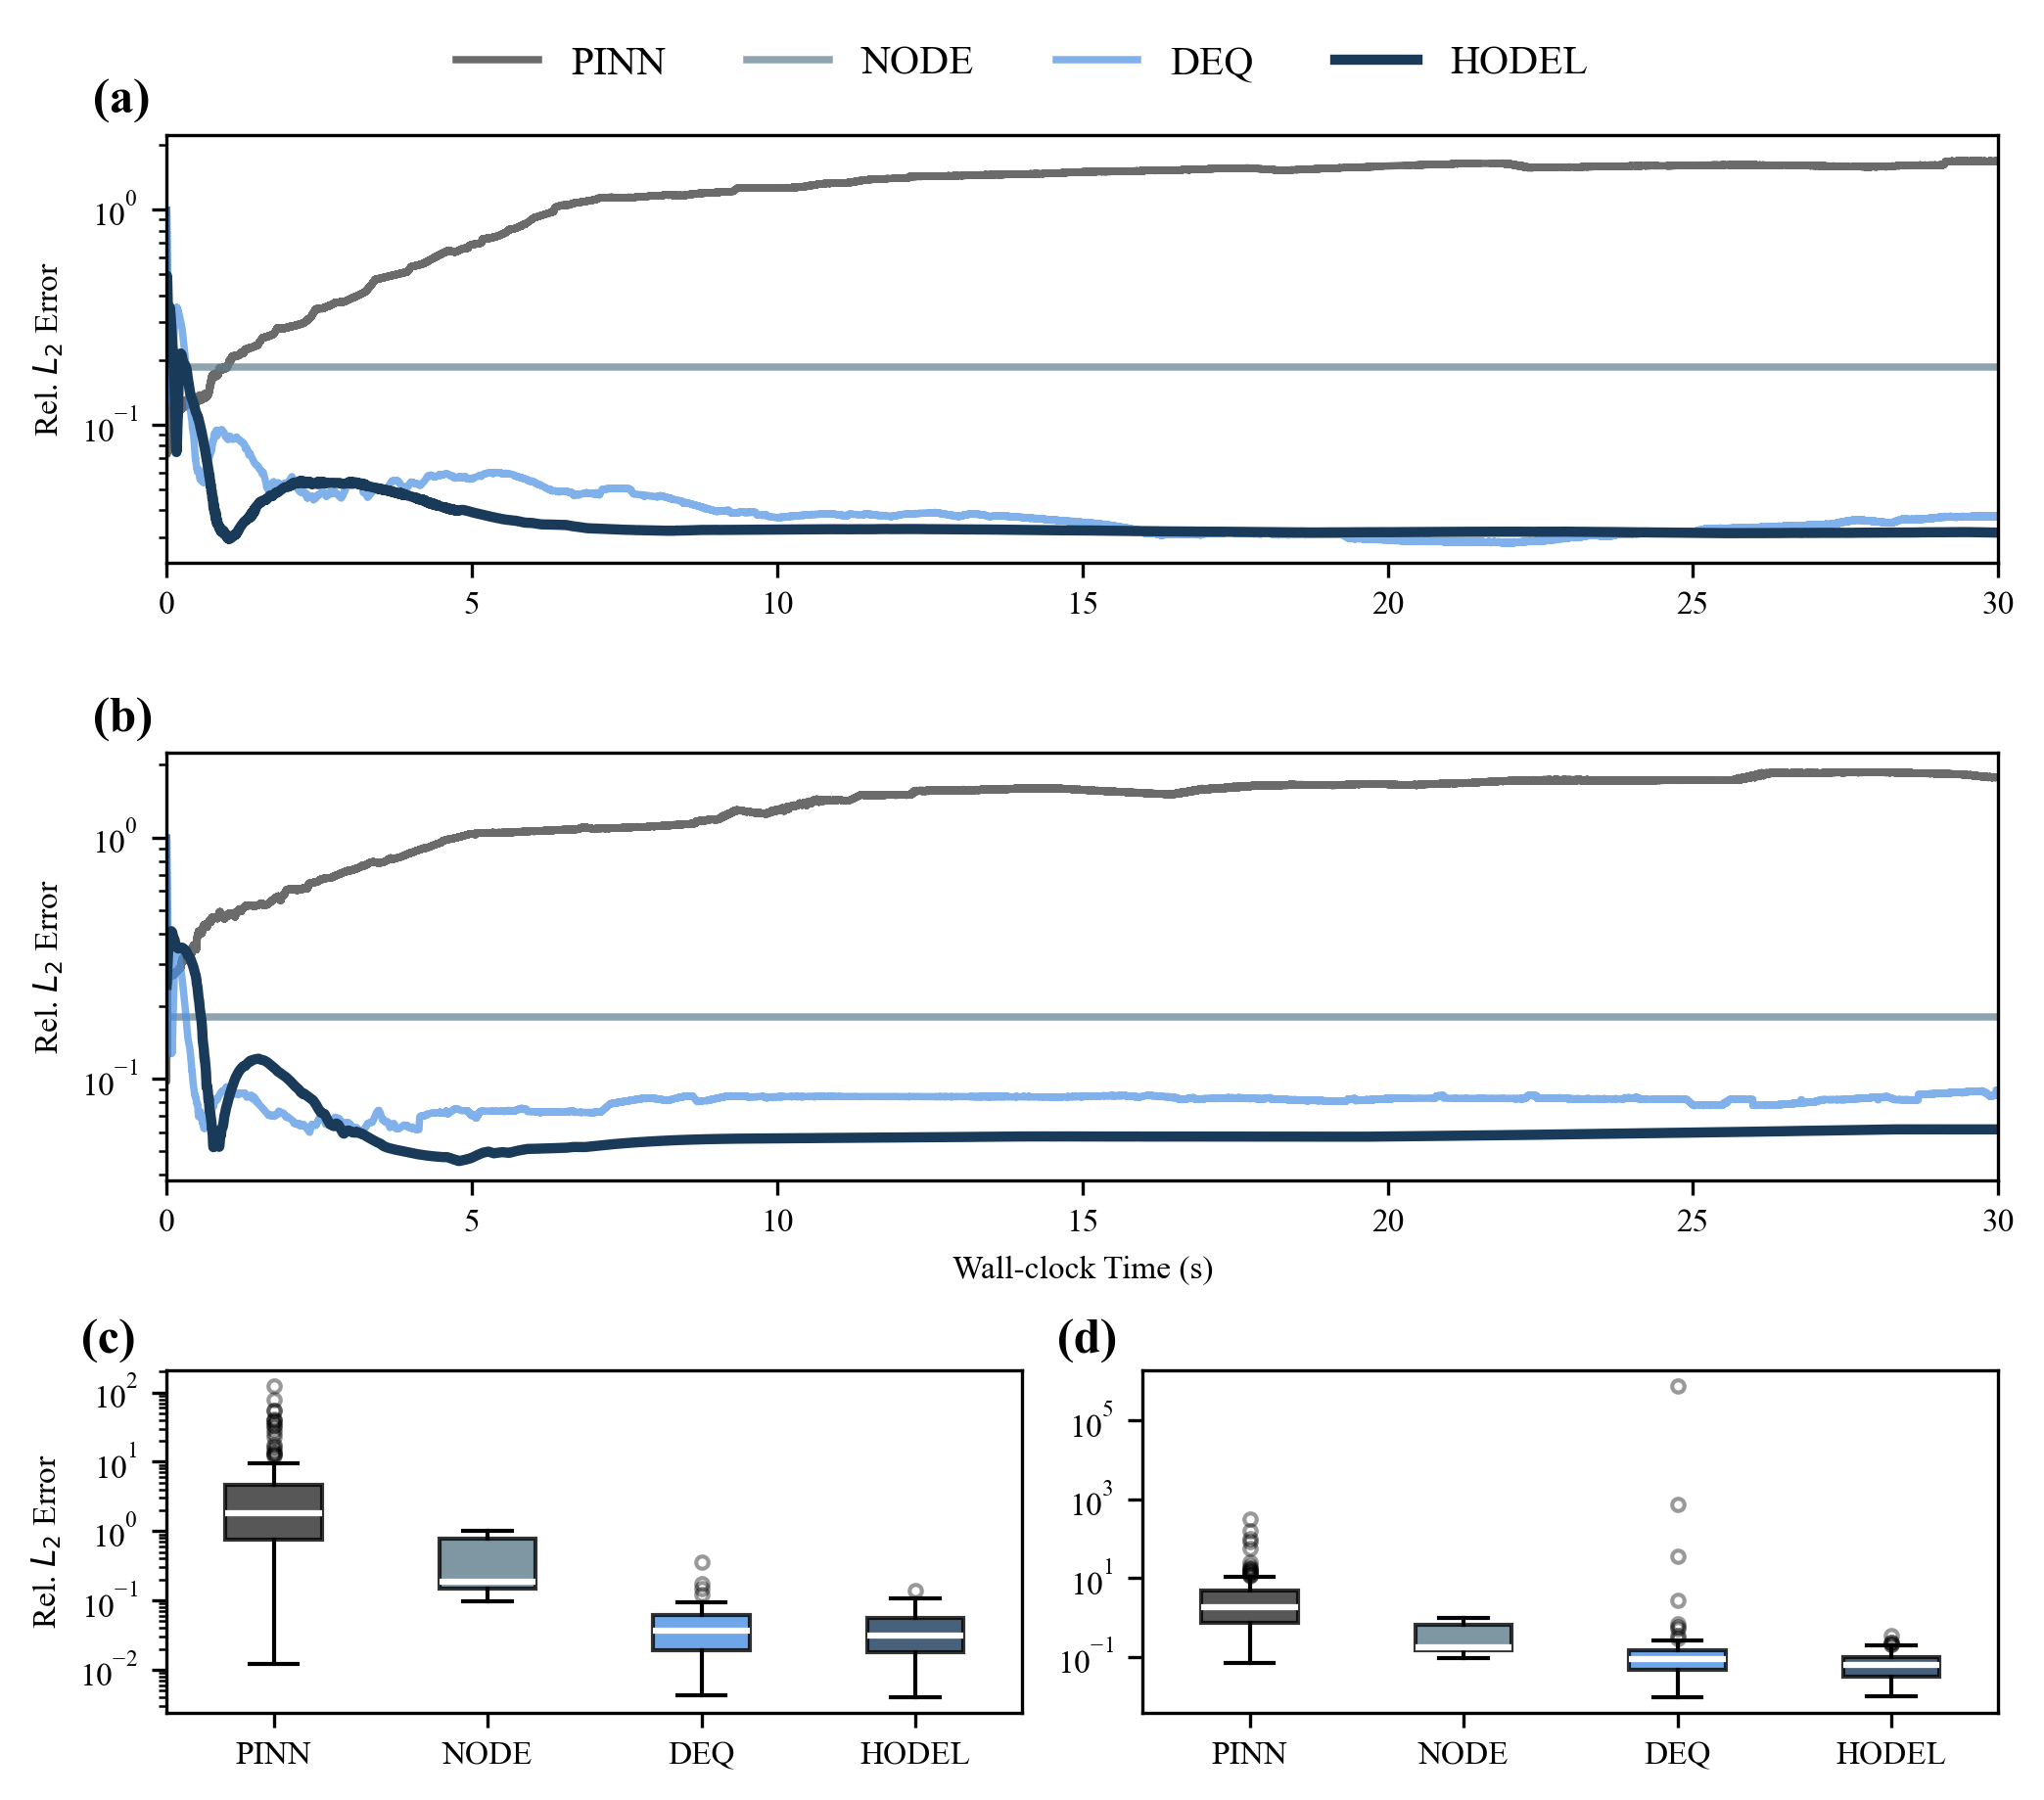

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import jax.numpy as jnp

# Settings
methods = ["pinn", "node", "deq", "hodel"]
etas = [0.01, 0.03]
colors = {
    "hodel": "#1A3A5A",
    "pinn": "#2d2d2d",
    "node": "#5f7d8c",
    "deq": "#4a90e2",
}
trim_t = 30.0

fig = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 0.8])
ax_top = fig.add_subplot(gs[0, :])
ax_mid = fig.add_subplot(gs[1, :])
ax_bot_l = fig.add_subplot(gs[2, 0])
ax_bot_r = fig.add_subplot(gs[2, 1])

curve_axes = [ax_top, ax_mid]
box_axes = [ax_bot_l, ax_bot_r]

for i, (e, ax) in enumerate(zip(etas, curve_axes)):
    for m in methods:
        path = f"data/results_{m}_eta={e}.npz"
        data = jnp.load(path)
        L_raw = data["test_errors"]
        nan_rows = jnp.isnan(L_raw).any(axis=1)
        L_clean = L_raw[~nan_rows] if jnp.sum(nan_rows) else L_raw
        avg_L = jnp.median(L_clean, axis=0)
        t_per_epoch = data["total_time"] / L_clean.size
        t = t_per_epoch * jnp.arange(avg_L.shape[0])
        ax.plot(
            t,
            avg_L,
            color=colors[m],
            label=m.upper(),
            lw=2.5 if m == "hodel" else 1.8,
            alpha=1.0 if m == "hodel" else 0.7,
        )
    ax.set_yscale("log")
    ax.set_xlim(0, trim_t)
    ax.set_ylabel("Rel. $L_2$ Error")
    if i == 1:
        ax.set_xlabel("Wall-clock Time (s)")
    ax.text(
        -0.04,
        1.13,
        f"({string.ascii_lowercase[i]})",
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )

for i, (e, ax) in enumerate(zip(etas, box_axes)):
    final_errors = []
    for m in methods:
        path = f"data/results_{m}_eta={e}.npz"
        data = jnp.load(path)
        L_raw = data["test_errors"]
        nan_rows = jnp.isnan(L_raw).any(axis=1)
        L_clean = L_raw[~nan_rows] if jnp.sum(nan_rows) else L_raw
        final_errors.append(L_clean[:, -1])

    bplot = ax.boxplot(
        final_errors,
        patch_artist=True,
        tick_labels=[m.upper() for m in methods],
        medianprops={"color": "white", "linewidth": 1.5},
        flierprops={"marker": "o", "markersize": 3, "alpha": 0.4},
    )
    for patch, m in zip(bplot["boxes"], methods):
        patch.set_facecolor(colors[m])
        patch.set_alpha(0.8)
    ax.set_yscale("log")
    if i == 0:
        ax.set_ylabel("Rel. $L_2$ Error")
    ax.text(
        -0.1,
        1.15,
        f"({string.ascii_lowercase[i + 2]})",
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )

handles, labels = ax_top.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.02),
    ncol=4,
    frameon=False,
    fontsize=10,
)

plt.tight_layout()
#plt.savefig(fname="1d_arruda_boyce_appendix.pdf", bbox_inches="tight")
plt.show()